In [16]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from tqdm import trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def optimize_value_model(model, criterion, optimizer, dataset, n_epochs=1000, batch_size=32):
    """
    Trains and evaluates the given model using the specified criterion and optimizer.
    Args:
        model (torch.nn.Module): The model to be trained and evaluated.
        criterion (torch.nn.Module): The loss function used to evaluate the model.
        optimizer (torch.optim.Optimizer): The optimizer used to update the model parameters.
        dataset (Dataset): The dataset object that provides training and testing data.
        n_epochs (int, optional): The number of epochs to train the model. Default is 1000.
        batch_size (int, optional): The number of samples per batch. Default is 32.
    Returns:
        tuple: A tuple containing two lists:
            - train_losses (list of float): The training loss recorded at each epoch.
            - test_losses (list of float): The testing loss recorded at each epoch.
    """
    train_losses = []
    test_losses = []
    train_task = []
    test_task = []
    for epoch in trange(n_epochs):
        model.train()
        X, y = dataset.generate_batch(batch_size, type='train', task="value")
        task = X[0, 0]
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_task.append(task)
        train_losses.append(loss.item())

        model.eval()
        X, y = dataset.generate_batch(batch_size, type='test', task="value")
        task = X[0, 0]
        y_pred = model(X)
        loss = criterion(y_pred, y)
        test_losses.append(loss.item())
        test_task.append(task)

        #if epoch % 100 == 0:
        #    print(f"Epoch {epoch}: Train Loss ({train_task[-1]}): {train_losses[-1]}, Test Loss ({test_task[-1]}): {test_losses[-1]}")
    return np.array(train_losses), np.array(test_losses), np.array(train_task), np.array(test_task)

In [30]:
d_model = 64
n_heads = 1
n_layers = 1
max_positions= 6
n_tokens = 10


dataset = rollout.dataset.InductionValueDataset(n_tokens, max_positions)
transformer1x1 = rollout.models.FlexibleTransformer(d_model, n_tokens+2, max_positions+1, n_heads, n_layers)
optimizer = optim.AdamW(transformer1x1.parameters(), lr=0.002)
criterion = nn.functional.cross_entropy

train_losses, test_losses, _, _ =optimize_value_model(transformer1x1, criterion, optimizer, dataset, n_epochs=1000, batch_size=100)


100%|██████████| 1000/1000 [00:04<00:00, 212.50it/s]


In [31]:
test_samples = dataset.generate_batch(100, type='test', task="value")

In [32]:
test_samples

(tensor([[11,  9,  0,  4,  5,  6,  0],
         [11,  8,  9,  0,  6,  3,  0],
         [11,  8,  6,  7,  3,  2,  8],
         [11,  8,  5,  6,  3,  9,  6],
         [11,  9,  6,  0,  4,  1,  9],
         [11,  9,  6,  2,  1,  5,  1],
         [11,  8,  2,  6,  1,  9,  1],
         [11,  8,  9,  7,  0,  2,  0],
         [11,  8,  4,  1,  7,  2,  4],
         [11,  8,  5,  3,  2,  4,  2],
         [11,  9,  5,  0,  7,  8,  9],
         [11,  8,  1,  5,  4,  6,  4],
         [11,  9,  5,  6,  4,  0,  5],
         [11,  8,  0,  9,  2,  3,  8],
         [11,  9,  6,  7,  0,  8,  7],
         [11,  9,  4,  8,  7,  6,  7],
         [11,  8,  0,  7,  4,  1,  8],
         [11,  8,  7,  5,  0,  3,  8],
         [11,  8,  3,  5,  2,  6,  3],
         [11,  8,  9,  7,  5,  4,  7],
         [11,  8,  3,  9,  2,  4,  8],
         [11,  9,  4,  6,  0,  1,  9],
         [11,  8,  5,  9,  1,  4,  1],
         [11,  9,  4,  1,  5,  3,  9],
         [11,  8,  5,  7,  9,  6,  5],
         [11,  8,  3,  1,

In [35]:
import rollout.plot as rplt

In [44]:
samp_i = 0

<Axes: >

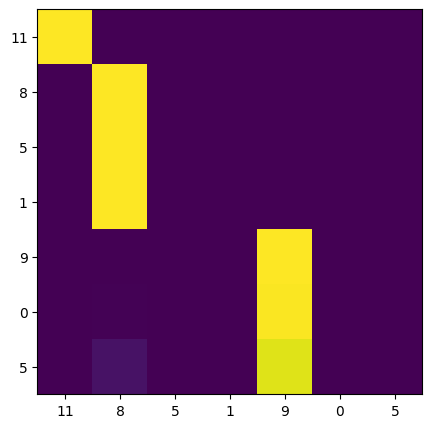

In [384]:
samp_i += 1
x = test_samples[0][samp_i].unsqueeze(0)
res = transformer1x1._fwd_internal(x, return_weights=True, return_residuals=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
rplt.plot_activation(res[1][0], samp=x, ax=ax)

In [533]:
QKV = rollout.utils.get_QKV(transformer1x1.attention_layers[0], d_model=64)
sample_all = torch.ones((10, 7), dtype=torch.long)*11
pos_all = np.zeros([10, 7])
for i in range(7):
    pos_all[:, i] = i

for i in range(10):
    sample_all[i, 1:] = i

num_idx = sample_all.detach().numpy().reshape(-1, 1)
pos_idx = pos_all.reshape(-1, 1)

embedding = rollout.utils.embed_proj(transformer1x1, sample_all.unsqueeze(0)).squeeze(0)
Q_proj = torch.einsum("ab, ...b -> ...a", QKV["Q"], embedding)
K_proj = torch.einsum("ab, ...b -> ...a", QKV["K"], embedding)
V_proj = torch.einsum("ab, ...b -> ...a", QKV["V"], embedding)

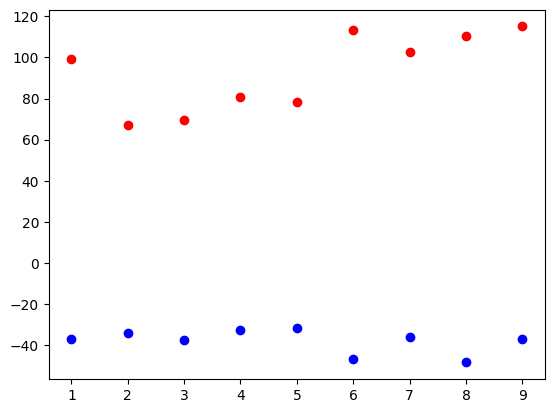

In [555]:
Q_pos = 1
K_pos = 2

for Q_val in range(1, 10):
    #Q_val = 3
    K_val = 9
    r = (Q_proj[Q_val, Q_pos] @ K_proj[K_val, K_pos]).detach().numpy()
    plt.plot(Q_val, r, "ro")

    K_val = 0
    r = (Q_proj[Q_val, Q_pos] @ K_proj[K_val, K_pos]).detach().numpy()
    plt.plot(Q_val, r, "bo")


In [580]:
from sklearn.decomposition import PCA


pca_model = PCA(n_components=60)
pca_out = pca_model.fit_transform(np.vstack([mat.detach().numpy().reshape(-1, d_model) for mat in [embedding, Q_proj, K_proj, V_proj]]))


embed_pca = pca_out[:70]
Q_pca = pca_out[70:140]
K_pca = pca_out[140:210]
V_pca = pca_out[210:]

n_relevant_dims = np.where(np.cumsum(pca_model.explained_variance_ratio_) > 0.9)[0][0]

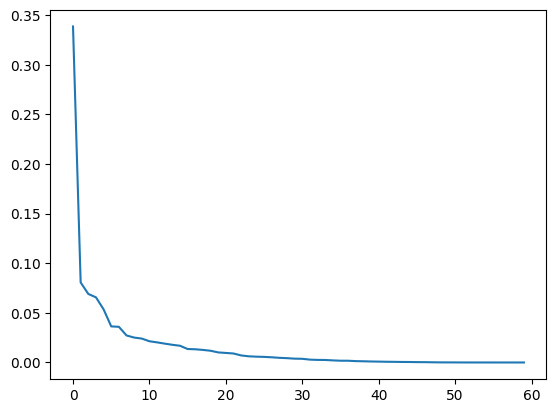

In [583]:
plt.plot(pca_model.explained_variance_ratio_)

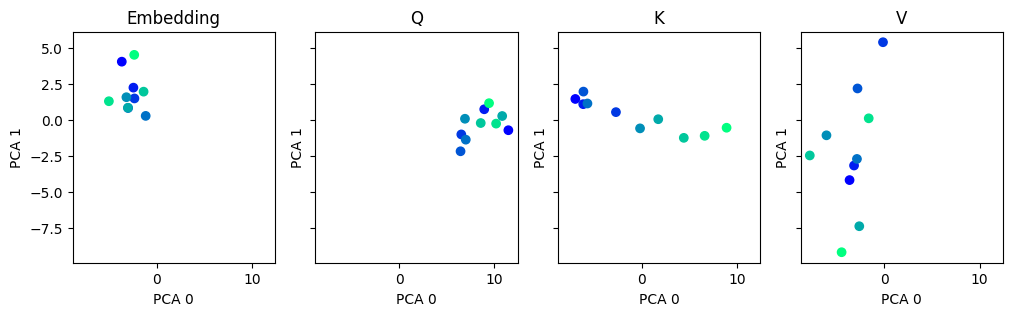

In [585]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 3))
dim1, dim2 = 0, 1
pos = 4
pos_i = (pos_idx == pos).ravel()
cmap = "winter"

def mean_dim(pca, num_idx, dim):
    return np.array([pca[(num_idx == num).ravel(), dim].mean() for num in range(10)])

ax[0].scatter(mean_dim(embed_pca, num_idx, dim1), mean_dim(embed_pca, num_idx, dim2), c=np.arange(10), cmap=cmap)
ax[0].set_title("Embedding")

ax[1].scatter(mean_dim(Q_pca, num_idx, dim1), mean_dim(Q_pca, num_idx, dim2), c=np.arange(10), cmap=cmap)
ax[1].set_title("Q")

ax[2].scatter(mean_dim(K_pca, num_idx, dim1), mean_dim(K_pca, num_idx, dim2), c=np.arange(10), cmap=cmap)
ax[2].set_title("K")
ax[3].scatter(mean_dim(V_pca, num_idx, dim1), mean_dim(V_pca, num_idx, dim2), c=np.arange(10), cmap=cmap)
ax[3].set_title("V")
for i in range(4):
    ax[i].set_xlabel(f"PCA {dim1}")
    ax[i].set_ylabel(f"PCA {dim2}")

##plt.scatter(Q_pca[:, 4], Q_pca[:, 4], c=num_idx, cmap='viridis_r')

(-1.0, 24.5)

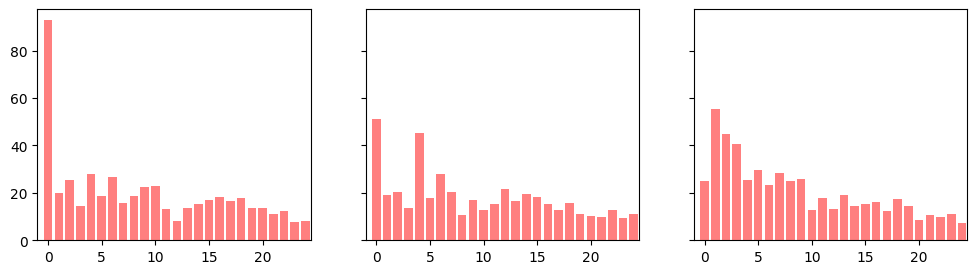

In [558]:
Q_norm = np.linalg.norm(embed_pca[:, :] - Q_pca[:, :], axis=0)
K_norm = np.linalg.norm(embed_pca[:, :] - K_pca[:, :], axis=0)
V_norm = np.linalg.norm(embed_pca[:, :] - V_pca[:, :], axis=0)


fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 3))
ax[0].bar(np.arange(0, 60), Q_norm, color='r', alpha=0.5, label="Q")
ax[1].bar(np.arange(0, 60), K_norm, color='r', alpha=0.5, label="Q")
ax[2].bar(np.arange(0, 60), V_norm, color='r', alpha=0.5, label="Q")
ax[0].set_xlim(-1, n_relevant_dims + 0.5)

In [349]:
decoder_weights = transformer1x1.classify.weight.detach().numpy()

<BarContainer object of 64 artists>

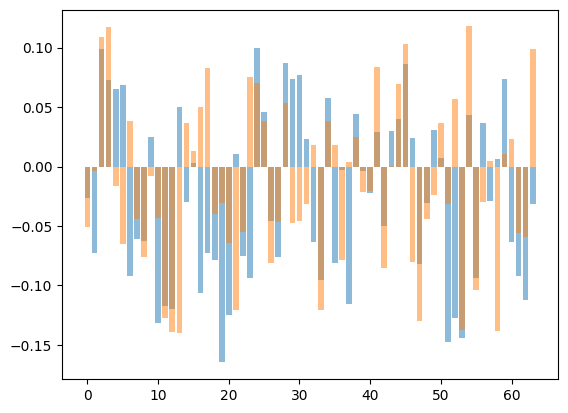

In [375]:
plt.bar(np.arange(0, 64), decoder_weights[0, :], alpha=0.5)
plt.bar(np.arange(0, 64), decoder_weights[-1, :], alpha=0.5)